##Building regression models that predict the hourly electrical energy output of a power plant

In [10]:
import pandas as pd

In [11]:
electricity = pd.read_excel(r'sample_data/Folds5x2_pp.xlsx')
print(electricity.info())
electricity.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB
None


,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56


###Deciding training set sizes
training set has 9568 instances
Train test split - 80:20

**For each specified size a new model is trained** 

In [12]:
train_sizes = [1, 100, 500, 2000, 5000, 7654]


*   **learning_curve()** function from the scikit-learn library to generate a learning curve for a regression model
*   It also sets aside Validation data set

*   learning_curve() **generates the data needed to plot a learning curve**. 
*   The **function returns** a tuple containing three elements: 
> the training set sizes, and the error scores on both the validation sets and the training sets
*   **Parameters**

> **estimator** — indicates the learning algorithm we use to estimate the true model

> **X** — the data containing the features;

> **y** — the data containing the target;

> **train_sizes** — specifies the training set sizes to be used;

> **cv** — determines the cross-validation splitting strategy

> **scoring** — indicates the error metric to use






In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve

features = ['AT', 'V', 'AP', 'RH']
target = 'PE'
train_sizes, train_scores, validation_scores = learning_curve(
estimator = LinearRegression(),
X = electricity[features],
y = electricity[target], train_sizes = train_sizes, cv = 5,
scoring = 'neg_mean_squared_error')

In [14]:
print('Training scores:\n\n', train_scores)
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', validation_scores)

Training scores:

 [[ -0.          -0.          -0.          -0.          -0.        ]
 [-19.71230701 -18.31492642 -18.31492642 -18.31492642 -18.31492642]
 [-18.14420459 -19.63885072 -19.63885072 -19.63885072 -19.63885072]
 [-21.53603444 -20.18568787 -19.98317419 -19.98317419 -19.98317419]
 [-20.47708899 -19.93364211 -20.56091569 -20.4150839  -20.4150839 ]
 [-20.98565335 -20.63006094 -21.04384703 -20.63526811 -20.52955609]]

 ----------------------------------------------------------------------

Validation scores:

 [[-619.30514723 -379.81090366 -374.4107861  -370.03037109 -373.30597982]
 [ -21.80224219  -23.01103419  -20.81350389  -22.88459236  -23.44955492]
 [ -19.96005238  -21.2771561   -19.75136596  -21.4325615   -21.89067652]
 [ -19.92863783  -21.35440062  -19.62974239  -21.38631648  -21.811031  ]
 [ -19.88806264  -21.3183303   -19.68228562  -21.35019525  -21.75949097]
 [ -19.9046791   -21.33448781  -19.67831137  -21.31935146  -21.73778949]]


learning_curve() runs a **k-fold cross-validation** under the hood, where the value of k is given by what we specify for the cv parameter.
Since cv = 5, so there will be five splits. For each split, an estimator is trained for every training set size specified

##**Training Error Score**

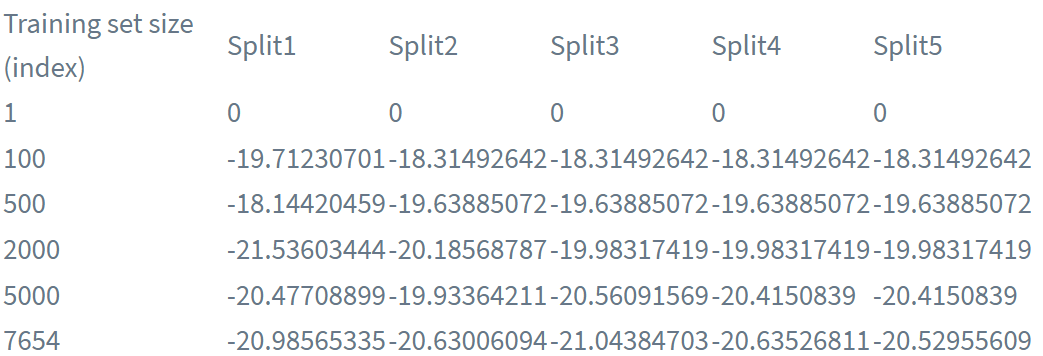

##Taking Error Average from each set

In [15]:
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))


Mean training scores

 1       -0.000000
100     18.594403
500     19.339921
2000    20.334249
5000    20.360363
7654    20.764877
dtype: float64

 --------------------

Mean validation scores

 1       423.372638
100      22.392186
500      20.862362
2000     20.822026
5000     20.799673
7654     20.794924
dtype: float64


##Plotting Learning Curves

<ipython-input-18-c3adbd5a4c25>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


(0.0, 40.0)

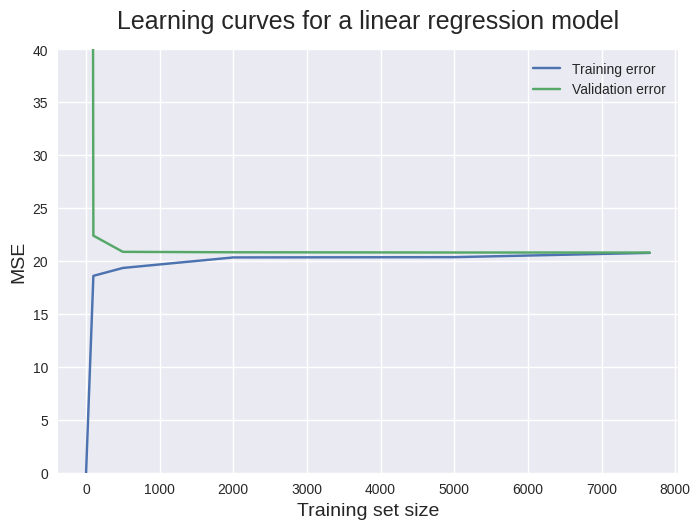

In [18]:
import matplotlib.pyplot as plt

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,40)

##**Observations**


*   When the training set size is 1, the MSE for the training set is 0. The prediction is perfect. But when tested on the validation set (which has 1914 instances), the MSE rockets up to roughly 423.4
*   When the training set size increases to 100, the **training MSE increases sharply, while the validation MSE decreases likewise.**
*   From 500 training data points onward, **the validation MSE stays roughly the same**

**IMP**

Adding more training data points won’t lead to significantly better models. So instead of wasting time (and possibly money) with collecting more data, we need to try something else, like switching to an algorithm that can build more complex model

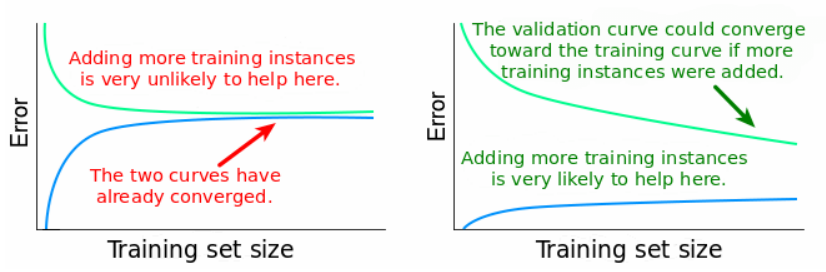

##Diagnosing bias and variance. 

The validation MSE stagnates at a value of approximately 20 i.e. 20MW (MegaWatts Squared)

Square root of 20 MW results in approximately 4.5 MW. Each target value represents net hourly electrical energy output. So **for each hour our model is off by 4.5 MW on average**. **This would add up if we tried to predict the total energy output for one day or a longer period.**

 MSE of 20 MW is quite large. 
 **Model has a bias problem.**

##**Low Bias or High Bias**


*    If the **training error is very low**, it means that the training data is fitted very well by the estimated model.
*   If the **model fits the training data very well**, it means it has **low bias** with respect to that set of data.
*   If the **training error is very high**,  it means that the training data is not fitted well enough by the estimated model.
*   If the **model fails** to fit the training data well, it means it has **high bias** with respect to that set of data.


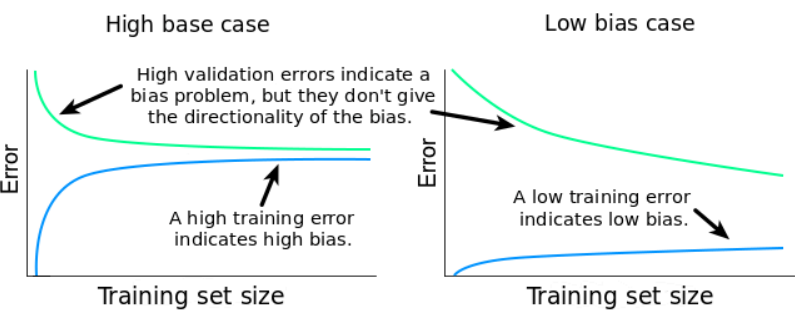



##Observation about Bias


*   The training MSE plateaus at a value of roughly 20 MW 2, which is **high error score.**
*   Because the **validation MSE is high**, and the **training MSE is high as well,**. Hence, the **model has high bais problem.**



##Observation about Variance

Estimating variance can be done in at least two ways:
*   By examining the gap between the validation learning curve and training learning curve.
*   By examining the training error: its value and its evolution as the training set sizes increase.



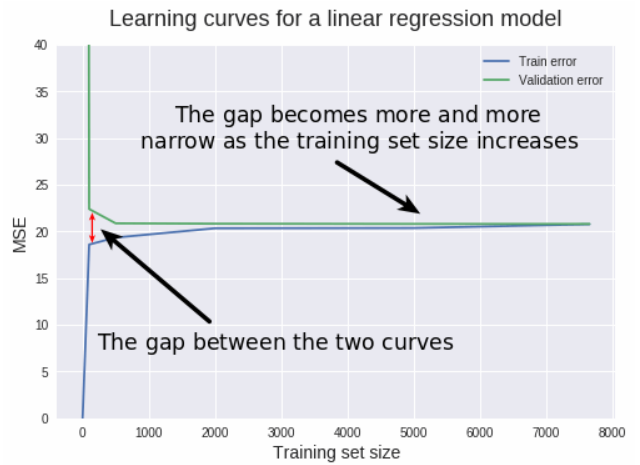

##Summary


*   A narrow gap indicates low variance. Generally, more narrow the gap, the lower the variance. 
*   Wider the gap, the greater the variance.
*   If variance is high, means model fits too well for the training data. Which will have generalizing on unseen data.
*   That means the training error will be low and the validation error will generally be high. 


The **differences between training and validation errors will determine that gap between the two learning curves**.
*   **gap = Validation error - Training error**
*   The **bigger the gap, the bigger the variance**
*   **Quick tip**: **High training MSE scores** are also a quick way to detect **low variance**.


Low Varaince means
*  The **algorithm** will come up with **simplistic** and similar models as we change the training sets
*   If the **models are overly simplified**, they **cannot even fit the training data well (they underfit the data).**

**high training MSEs can be used as indicators of low variance**.

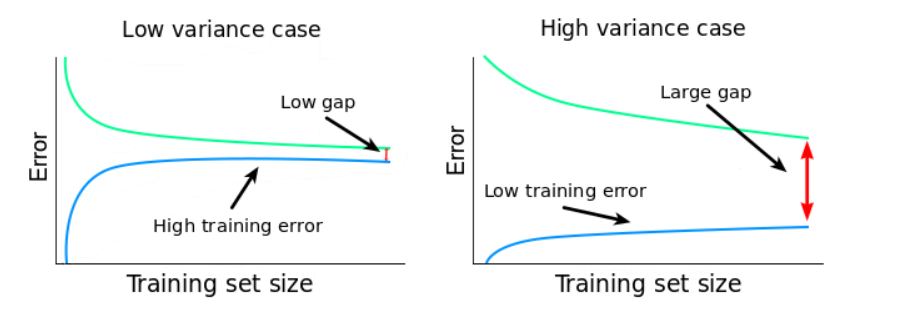

## Conclusion for Case study
* training MSE plateaus at around 20, which is High Value.
* narrow gap from graph confirms low variance problem

**Our learning algorithm suffers from high bias and low variance, underfitting the training data.**
Adding more instances (rows) to the training data is hugely unlikely to lead to better models under the current learning algorithm.

**Other Options**


*   Training the current learning algorithm on **more features**. This can **lower the bias** by **increasing the model’s complexity**.
*   Decreasing the regularization of the current learning algorithm.


> **Regularization** is a technique used **in an attempt to solve the overfitting problem in statistical models.**
> Can use **cross validation** to take care of overfitting. 






#Learning Curves - Low Bias and High Variance

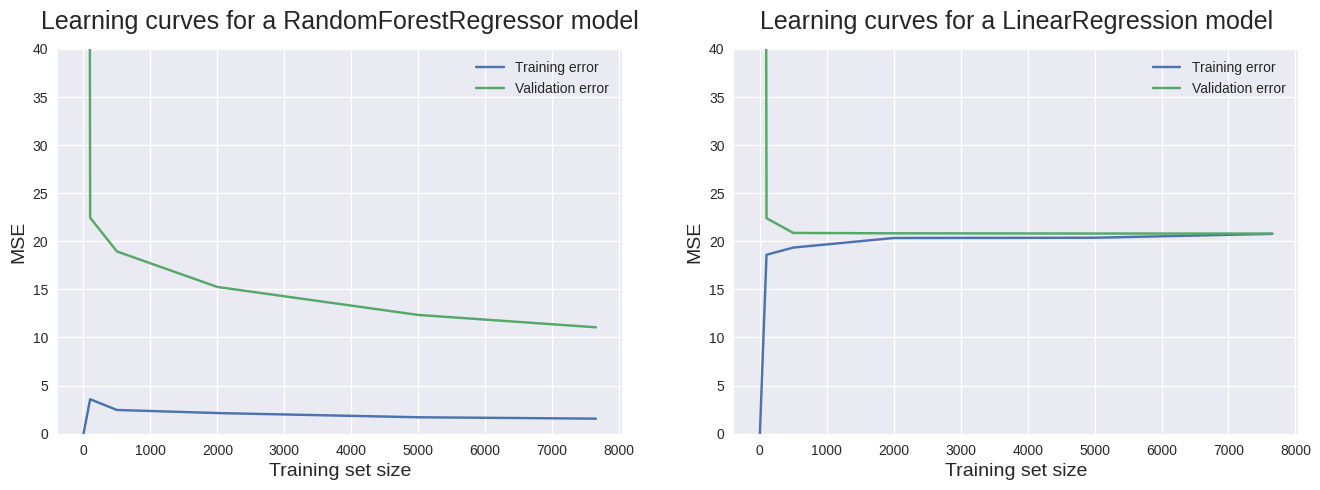

In [17]:
def learning_curves(estimator, data, features, target, train_sizes, cv):
   train_sizes, train_scores, validation_scores = learning_curve(
    estimator, data[features], data[target], train_sizes =
    train_sizes,
    cv = cv, scoring = 'neg_mean_squared_error')
   train_scores_mean = -train_scores.mean(axis = 1)
   validation_scores_mean = -validation_scores.mean(axis = 1)

   plt.plot(train_sizes, train_scores_mean, label = 'Training error')
   plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

   plt.ylabel('MSE', fontsize = 14)
   plt.xlabel('Training set size', fontsize = 14)
   title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
   plt.title(title, fontsize = 18, y = 1.03)
   plt.legend()
   plt.ylim(0,40)

### Plotting the two learning curves ###

from sklearn.ensemble import RandomForestRegressor

plt.figure(figsize = (16,5))

for model, i in [(RandomForestRegressor(), 1), (LinearRegression(),2)]:
    plt.subplot(1,2,i)
    learning_curves(model, electricity, features, target, train_sizes, 5)

###Observation wrt Random Forest


*   **new gap** between the two learning curves suggests a substantial **increase in variance**

*   The **low training MSEs** corroborate this diagnosis of high variance
*    The large gap and the low training error also indicates an **overfitting problem.** 
*    Adding new training instances is very likely to lead to better models
*    Validation curve still has potential to decrease and converge toward the training curve similar to linear regression.

**Summary**
*    Our learning algorithm (random forests) **suffers from high variance and quite a low bias, overfitting the training data**.
*    **Adding more training instances** is **very likely to lead to better models** under the current learning algorithm.

##Suggestions to decrease validation MSE


*   Adding more training instances.
*   Adding more features.
*   Feature selection.
*   Hyperparameter optimization



##The ideal learning curves and the irreducible error
*  both curves converge toward an MSE of 0. But its impossible because of irreducible error.
*  Y = f(X) + reducible_error
*  x are the features, that are known to us
*  its possible to have other features(which are not avaiblable to us) that influence Y. They introduce irreducible error


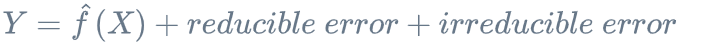

##Web References
https://www.dataquest.io/blog/learning-curves-machine-learning/
